In [1]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,fastcluster,pvclust,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

## Read in metadata-linked abundances from `process-abundance-data.ipynb`

In [2]:
sam_with_meta_bact <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact.csv")))
sam_with_meta <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk.csv")))
data_tree_bact <- data.frame(fread(file.path("..","..","data","data_tree_bact.csv")))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))

In [3]:
sam_with_meta_bact_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact_filt.csv")))
sam_with_meta_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk_filt.csv")))

In [4]:
mag_abund_frame = data.frame(fread("../../data/mag_abund_res_90perc_top20.csv"))
metadata_file = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                                   "meta-lakes/meta-lakes-pipeline/data/all_metadata_12May.csv"))
metadata_file["SampleDate"] = "1900-01-01"
for (curr in 1:nrow(metadata_file)) {
    curr_token = metadata_file$Analysis.Project.Analysis.Project.Name[curr]

    if (grepl("ME", curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-ME"))
        curr_token = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
        sample_date = curr_token
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "D"))
        sample_date = listed_meta[1]
        curr_token = sample_date
        if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } 
    } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
        listed_meta = unlist(strsplit(curr_token, "s"))
        sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
    } else if (!is.na(curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-"))
        sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
    } else {
        sample_date = ""
    }

    if (grepl("Fre",sample_date)) {
        sample_date = "Control"
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        sample_date = unlist(strsplit(sample_date,"D"))[1]

        if (grepl("s", tolower(sample_date)) & !grepl("sep", tolower(sample_date))) {

            sample_date = unlist(strsplit(sample_date, "s"))[1]
        }
        metadata_file$SampleDate[curr] = sample_date
    } else {
        metadata_file$SampleDate[curr] = sample_date
    }


}
mag_abund_frame = mag_abund_frame %>%
    dplyr::left_join(metadata_file)

Joining, by = "SeqProjID"


In [5]:
for_plotting = sam_with_meta %>% dplyr::inner_join(data_tree_euk, by = c("X.rname" = "label","Label"))

for (row_curr in c(1:nrow(for_plotting))) {
    if (trimws(for_plotting$Phylum[row_curr]) == "Metazoa") {
        extra_slots = unlist(strsplit(for_plotting$AllOthers[row_curr],";"))
        if (length(extra_slots) == 11) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[5])
            for_plotting$Order[row_curr] = trimws(extra_slots[9])
            for_plotting$Family[row_curr] = trimws(extra_slots[10])
            for_plotting$Genus[row_curr] = trimws(extra_slots[11])
        } else if (length(extra_slots == 7)) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[3])
            for_plotting$Order[row_curr] = trimws(extra_slots[5])
            for_plotting$Family[row_curr] = trimws(extra_slots[6])
            for_plotting$Genus[row_curr] = trimws(extra_slots[7])
        }
        print(for_plotting[row_curr,])
    }
    if (trimws(for_plotting$Phylum[row_curr]) == "Opisthokonta") {
            for_plotting$Phylum[row_curr] = "Choanozoa"
            for_plotting$Class[row_curr] = "Ichthyosporea"
            for_plotting$Order[row_curr] = "Eccrinida"
            for_plotting$Family[row_curr] = "Piridae"
            for_plotting$Genus[row_curr] = "Pirum"
    }
    
    if (trimws(for_plotting$Phylum[row_curr]) == "Cryptophyceae") {
        for_plotting$Genus[row_curr] = for_plotting$Family[row_curr]
        for_plotting$Family[row_curr] = for_plotting$Order[row_curr]
        for_plotting$Order[row_curr] = for_plotting$Class[row_curr]
        for_plotting$Class[row_curr] = for_plotting$Phylum[row_curr]
        for_plotting$Phylum[row_curr] = "Cryptophyta"
    }
    
    if (trimws(for_plotting$Order[row_curr]) == "Fragilariophyceae") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    } else if (trimws(for_plotting$Class[row_curr]) == "Bacillariophyta") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    }
}
curr_cm="RF01960"
for_plotting = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    dplyr::ungroup()

In [6]:
create_sam_meta <- function(samtools) {
    metadata_file["SampleDate"] = "1900-01-01"
    for (curr in 1:nrow(metadata_file)) {
        curr_token = metadata_file$Analysis.Project.Analysis.Project.Name[curr]
        
        if (grepl("ME", curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "-ME"))
            curr_token = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
            sample_date = curr_token
        }
        if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "D"))
            sample_date = listed_meta[1]
            curr_token = sample_date
            if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

                listed_meta = unlist(strsplit(curr_token, "s"))
                sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
            } 
        } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } else if (!is.na(curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "-"))
            sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
        } else {
            sample_date = ""
        }
        
        if (grepl("Fre",sample_date)) {
            sample_date = "Control"
        }
        if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
            sample_date = unlist(strsplit(sample_date,"D"))[1]
            
            if (grepl("s", tolower(sample_date)) & !grepl("sep", tolower(sample_date))) {

                sample_date = unlist(strsplit(sample_date, "s"))[1]
            }
            metadata_file$SampleDate[curr] = sample_date
        } else {
            metadata_file$SampleDate[curr] = sample_date #unlist(strsplit(sample_date,"D"))[1]
        }
        
        
    }
    #return(metadata_file)
    
    sam_with_meta = samtools %>% dplyr::left_join(metadata_file %>% 
                                                  dplyr::mutate(SeqIDs = as.character(SeqIDs)),
                              by=c("Sample" = "SeqIDs"))
    return(sam_with_meta)
}

create_sam_meta_wrong <- function(samtools) {
    samtools = samtools %>% dplyr::left_join(metadata_file %>% dplyr::mutate(SeqIDs = as.character(SeqIDs)),
                              by=c("Sample" = "SeqIDs"))
    metadata_file["SampleDate"] = "1900-01-01"
    for (curr in 1:nrow(metadata_file)) {
        curr_token = metadata_file$Analysis.Project.Analysis.Project.Name[curr]
        if (grepl("ME", curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "-ME"))
            sample_date = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
        } else if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "D"))
            sample_date = strsplit(listed_meta[1])
            if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

                listed_meta = unlist(strsplit(curr_token, "s"))
                sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
            }
        } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } else if (!is.na(curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "-"))
            sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
        } else {
            sample_date = ""
        }
        
        if (grepl("Fre",sample_date)) {
            sample_date = "Control"
        }
        if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
            sample_date = unlist(strsplit(sample_date,"D"))[1]
            
            if (grepl("s", tolower(sample_date)) & !grepl("sep", tolower(sample_date))) {

                sample_date = unlist(strsplit(sample_date, "s"))[1]
            }
            metadata_file$SampleDate[curr] = sample_date
        } else {
            metadata_file$SampleDate[curr] = sample_date #unlist(strsplit(sample_date,"D"))[1]
        }
        
    }
    sam_with_meta = samtools %>% dplyr::left_join(metadata_file %>% 
                                                  dplyr::mutate(SeqIDs = as.character(SeqIDs)),
                              by=c("Sample" = "SeqIDs"))
    return(sam_with_meta)
}

create_sam_meta_slow <- function(samtools) {
    sam_with_meta = samtools %>% dplyr::left_join(metadata_file %>% dplyr::mutate(SeqIDs = as.character(SeqIDs)),
                                  by=c("Sample" = "SeqIDs"))
    sam_with_meta["SampleDate"] = "1900-01-01"
    for (curr in 1:nrow(sam_with_meta)) {
        curr_token = sam_with_meta$Analysis.Project.Analysis.Project.Name[curr]
        if (grepl("ME", curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "-ME"))
            curr_token = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
            sample_date = curr_token
        }
        if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "D"))
            sample_date = listed_meta[1]
            if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

                listed_meta = unlist(strsplit(curr_token, "s"))
                sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
            }
        } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } else if (!is.na(curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "-"))
            sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
        } else {
            sample_date = ""
        }
        if (sample_date == "Fre") {
            sample_date = "Control"
        }
        sam_with_meta$SampleDate[curr] = sample_date
    }
    return(sam_with_meta)
}

create_for_plotting <- function(for_plotting) {
    for (row_curr in c(1:nrow(for_plotting))) {
        if (trimws(for_plotting$Phylum[row_curr]) == "Metazoa") {
            extra_slots = unlist(strsplit(for_plotting$AllOthers[row_curr],";"))
            if (length(extra_slots) == 11) {
                for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
                for_plotting$Class[row_curr] = trimws(extra_slots[5])
                for_plotting$Order[row_curr] = trimws(extra_slots[9])
                for_plotting$Family[row_curr] = trimws(extra_slots[10])
                for_plotting$Genus[row_curr] = trimws(extra_slots[11])
            } else if (length(extra_slots == 7)) {
                for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
                for_plotting$Class[row_curr] = trimws(extra_slots[3])
                for_plotting$Order[row_curr] = trimws(extra_slots[5])
                for_plotting$Family[row_curr] = trimws(extra_slots[6])
                for_plotting$Genus[row_curr] = trimws(extra_slots[7])
            }
        }
        if (trimws(for_plotting$Phylum[row_curr]) == "Opisthokonta") {
                for_plotting$Phylum[row_curr] = "Choanozoa"
                for_plotting$Class[row_curr] = "Ichthyosporea"
                for_plotting$Order[row_curr] = "Eccrinida"
                for_plotting$Family[row_curr] = "Piridae"
                for_plotting$Genus[row_curr] = "Pirum"
        }
    }
    for_plotting = for_plotting %>%
        dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                      Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")))
    return(for_plotting)
}
print("done step 1")
data_tree_bact$TipLabs = data_tree_bact$label
for (curr_ind in 1:nrow(data_tree_bact)) {
  curr_splitter = unlist(strsplit(as.character(data_tree_bact$TipLabs[curr_ind]),"\\|"))
  if (!is.null(curr_splitter)) {
      data_tree_bact$TipLabs[curr_ind] = unlist(strsplit(unlist(strsplit(curr_splitter[length(curr_splitter)],
                                                                         "\\."))[1],"SSU_"))[1]
  }
}


sam_with_meta_bact$X.rname = sapply(strsplit(as.character(vapply(strsplit(sam_with_meta_bact$X.rname,
                                                                                   "SSU_"), `[`, 1, 
                                    FUN.VALUE=character(1))), "\\|"), tail, 1)
#sam_with_meta_bact$X.rname = vapply(strsplit(vapply(strsplit(sam_with_meta_bact$X.rname,"SSU_"), `[`, 1, 
#                                    FUN.VALUE=character(1)), `|`, 2, 
#                                    FUN.VALUE=character(1)))
#}
#lapply(lapply(sam_with_meta_bact$X.rname, strstrip, "SSU_"),unlist)

for_plotting_bact = sam_with_meta_bact %>% dplyr::inner_join(data_tree_bact,
                                                             by = c("X.rname" = "TipLabs","Label"))%>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    dplyr::ungroup()

[1] "done step 1"


In [7]:
modified_abundance_frame = for_plotting %>% dplyr::bind_rows(for_plotting_bact %>% 
                                         dplyr::mutate(DateFormatted=as.Date(SampleDate,format="%d%b%Y"))%>% 
                                         dplyr::mutate(Month=lubridate::month(DateFormatted))) %>% 
       dplyr::distinct(Label,Phylum,Class,Order,Family,Genus,SampleDate,.keep_all=TRUE) %>%
       tidyr::pivot_wider(id_cols=c(Label,Phylum,Class,Order,Family,Genus),
                          values_from="ZScore",names_from="SampleDate")

In [8]:
# create a dataframe to identify the highest abundance taxon per month as well as the 
# number of identified organisms in each month.
trends_abundance_frame = for_plotting %>% dplyr::bind_rows(for_plotting_bact %>% 
                                         dplyr::mutate(DateFormatted=as.Date(SampleDate,format="%d%b%Y"))%>% 
                                         dplyr::mutate(Month=lubridate::month(DateFormatted)))

In [9]:
max_order = trends_abundance_frame %>% dplyr::group_by(Month,Order,Domain) %>% 
     dplyr::summarize(summedTPM = sum(TPM,na.rm=TRUE)) %>%
     dplyr::group_by(Month,Domain) %>%
     dplyr::filter(summedTPM == max(summedTPM))

max_family = trends_abundance_frame %>% dplyr::group_by(Month,Family,Domain) %>% 
     dplyr::summarize(summedTPM = sum(TPM,na.rm=TRUE)) %>%
     dplyr::group_by(Month,Domain) %>%
     dplyr::filter(summedTPM == max(summedTPM))

mean_tpm = trends_abundance_frame %>% dplyr::group_by(Month,Family,Label,SampleDate,Domain) %>% 
     dplyr::summarize(summedTPM = sum(TPM,na.rm=TRUE)) #%>%
     #dplyr::group_by(Month,Domain) %>%
     #dplyr::summarize(meanTPM = mean(summedTPM, na.rm = TRUE))

num_orders = trends_abundance_frame %>% 
     dplyr::filter(TPM > 100) %>%
     dplyr::distinct(Month,Order,Domain,SampleDate,.keep_all=TRUE) %>%
     dplyr::group_by(Month,Domain,SampleDate) %>%
     dplyr::tally()

`summarise()` has grouped output by 'Month', 'Order'. You
can override using the `.groups` argument.
`summarise()` has grouped output by 'Month', 'Family'. You
can override using the `.groups` argument.
`summarise()` has grouped output by 'Month', 'Family',
'Label', 'SampleDate'. You can override using the `.groups`
argument.


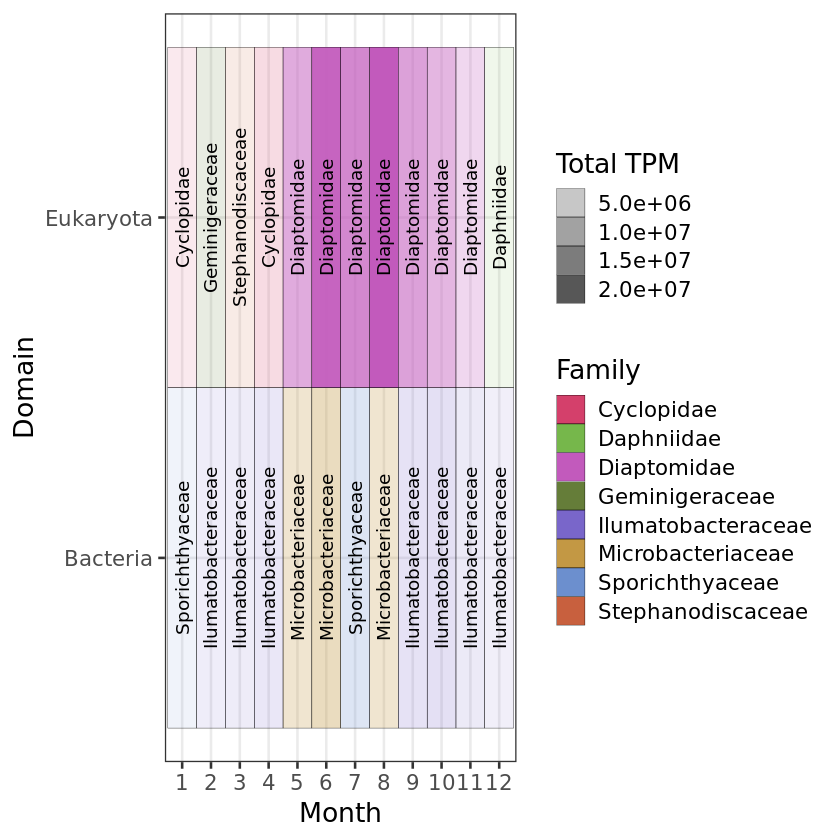

In [16]:
distinct_cols = c("#9f4764", "#58cb5f", "#be54c4", "#4fa433", "#7166d9", "#b0bf2e", "#8b57a1", 
                  "#92bc43", "#d24790", "#55bd81", "#d23d55", "#51c6c0", "#d24b29", "#60a2d7", 
                  "#de882f", "#6077c3", "#d0b13d", "#d08dce", "#417d23", "#e07f89", "#408147", 
                  "#e98060", "#338b70", "#a35630", "#77902d", "#d4a268", "#636f2d", "#9fb56c", 
                  "#86672d", "#9d8527", "black")
distinct_cols = c("#d4406b","#76b74b","#c25abc","#657d39","#7966ca",
                  "#c39844","#6c8fce","#c8603e","#4db598","#bd6a8e")

top_order_plot = ggplot(max_family %>% dplyr::filter(!is.na(Month))) + 
    #geom_label(aes(y = Domain, x = factor(Month), label = Order, fill = summedTPM),
    #                           position=position_jitter(width=0,height=1),color="black",angle=45)+
    geom_tile(aes(x = factor(Month), y = Domain, fill = Family, alpha = summedTPM),color="black") + 
    geom_text(aes(y = Domain, x = factor(Month), label = Family), angle = 90) + 
    scale_fill_manual(values=distinct_cols) + 
    #scale_fill_gradient(low = "light blue", high = "orange", name = "Total TPM") + 
    theme_bw(base_size=16) + xlab("Month") + scale_alpha(name = "Total TPM")
top_order_plot

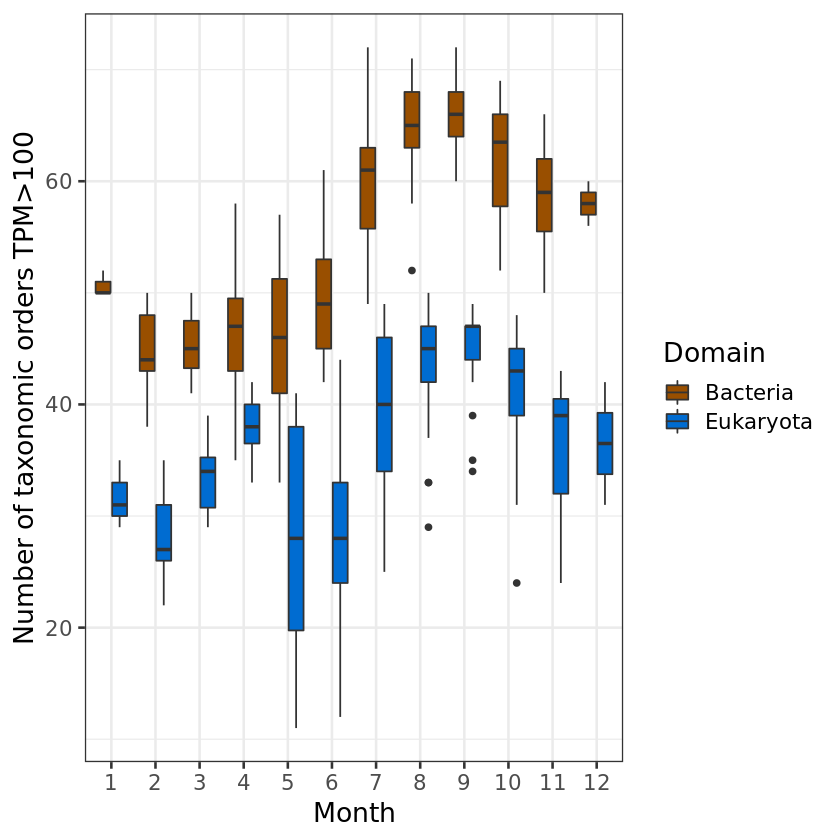

In [17]:
num_order_plot = ggplot(num_orders %>% dplyr::filter(!is.na(Month))) + 
    geom_boxplot(aes(x = factor(Month), y = n, fill = Domain)) +
    theme_bw(base_size=16) + ylab("Number of taxonomic orders TPM>100") + xlab("Month") + 
    scale_fill_manual(values=c("#994F00","#006CD1"))
num_order_plot

Picking joint bandwidth of 0.157



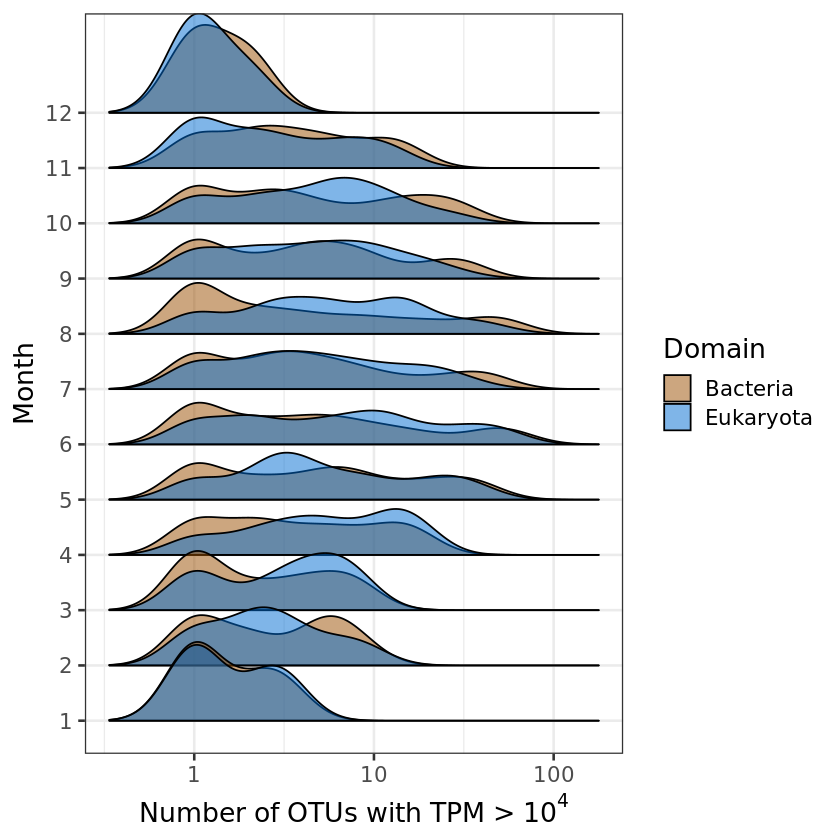

In [18]:
num_high_abund_plot = ggplot(mean_tpm %>% dplyr::filter(!is.na(Month)) %>% dplyr::filter(summedTPM > 10000) %>%
       dplyr::group_by(Label,Domain,Month) %>% dplyr::tally(),
       aes(y = factor(Month), x = summedTPM, fill = Domain)) + 
    geom_density_ridges2(aes(x = n, y = factor(Month), color = Domain, 
                             group = paste0(factor(Month),Domain)), color = "black",
                         alpha = 0.5) +
    theme_bw(base_size=16) + 
    #xlab("Number of OTUs with TPM>10000") +
    xlab(expression(paste("Number of OTUs with ","TPM > 10"^{4})))+
    ylab("Month") + 
    scale_fill_manual(values=c("#994F00","#006CD1")) + scale_x_log10() #+ 
    #facet_wrap(~Domain,ncol = 1)
num_high_abund_plot

In [19]:
fit <- pvclust(modified_abundance_frame %>% 
               dplyr::select(-c(Label,Phylum,Class,Order,Family,Genus)), 
               method.hclust="ward.D", method.dist="canberra",parallel=TRUE)

Creating a temporary cluster...done:
socket cluster with 35 nodes on host ‘localhost’
Multiscale bootstrap... Done.


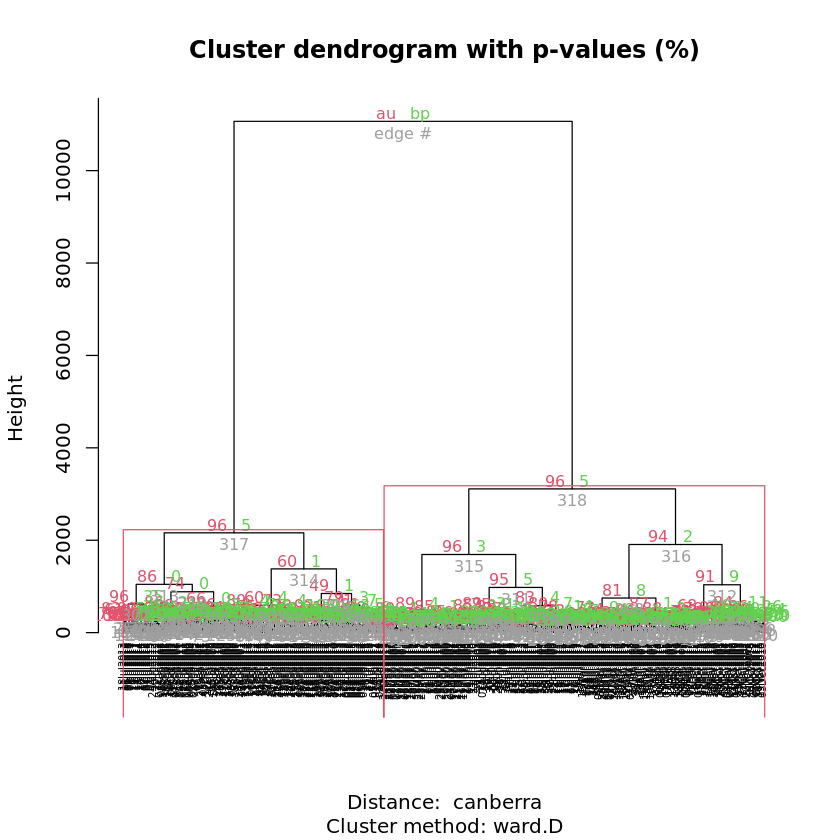

In [20]:
plot(fit, hang = -1, cex = 0.5)
pvrect(fit, alpha=.95, pv="au", type="geq")

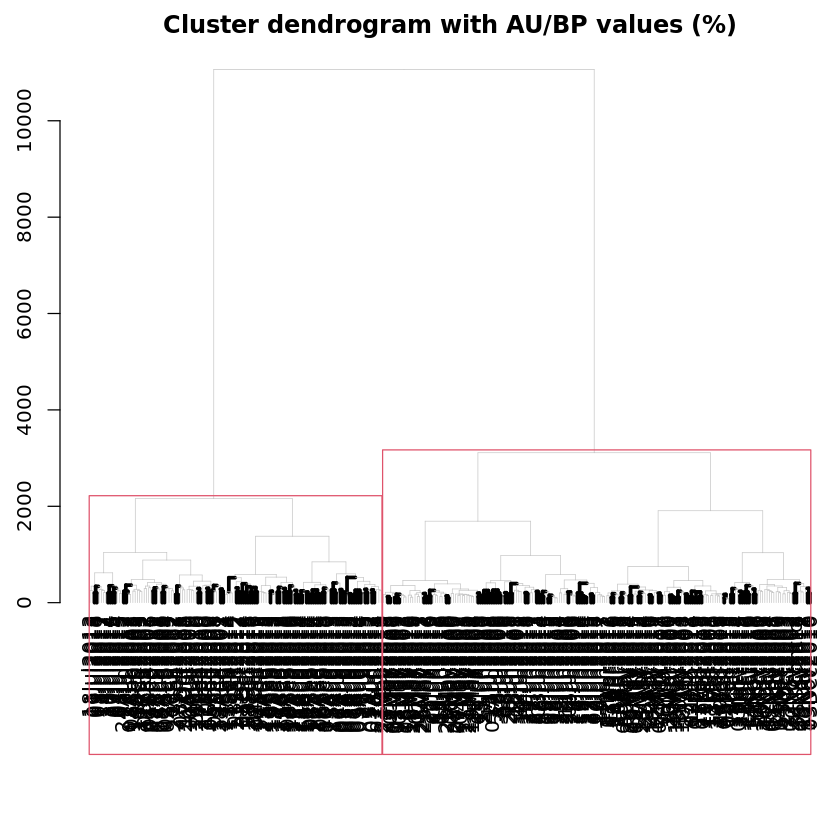

In [21]:
par(mar = c(9, 2.5, 2, 0))
dend <- as.dendrogram(fit)
dend %>%
  pvclust_show_signif(fit, signif_value = c(3, .5)) %>%
  pvclust_show_signif(fit, signif_value = c("black", "grey"), show_type = "col") %>%
  plot(main = "Cluster dendrogram with AU/BP values (%)")
pvrect2(fit, alpha = 0.95)

In [22]:
pp = pvpick(fit, alpha=0.95, pv="au", type="geq", max.only=TRUE)
clusters = pp$clusters
cluster_ct = 1
all_df = data.frame()
for (cluster in clusters) {
    all_df = all_df %>% dplyr::bind_rows(data.frame("Date"=cluster,"ClustNum"=cluster_ct)%>% 
                                         dplyr::mutate(DateFormatted=as.Date(Date,format="%d%b%Y"))%>% 
                                         dplyr::mutate(Month=lubridate::month(DateFormatted)))
    cluster_ct = cluster_ct + 1
}

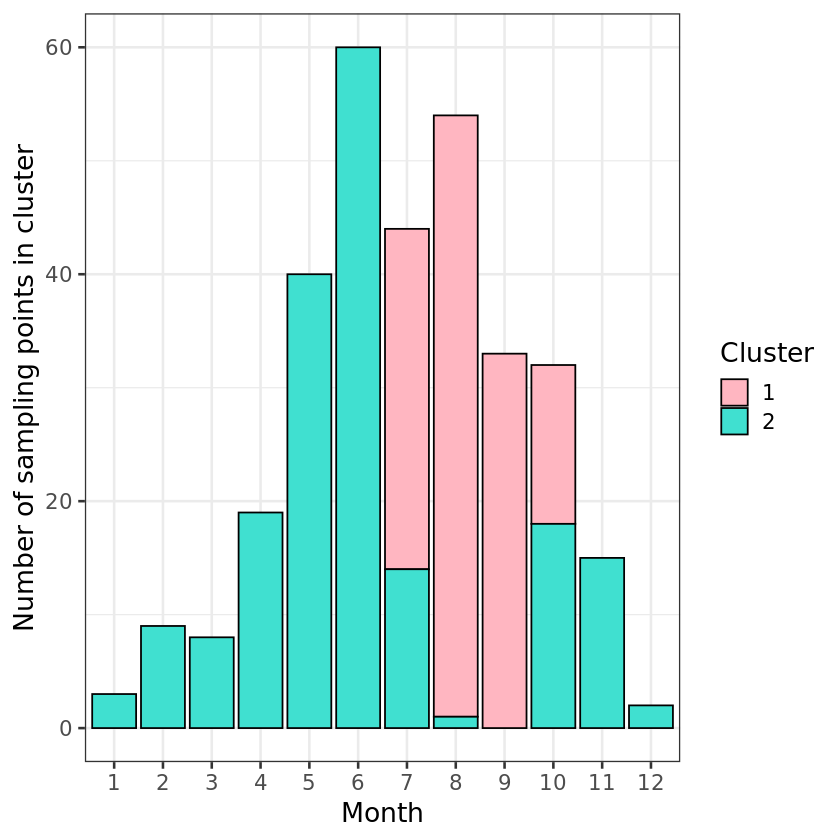

In [23]:
cluster_plot = ggplot(all_df %>% dplyr::filter(!is.na(Month)) %>% 
       dplyr::group_by(Month,ClustNum) %>% dplyr::tally()) + 
    geom_bar(aes(x = factor(Month),
                 y = n, fill = factor(ClustNum)),
             color="black",stat="identity") + 
    xlab("Date") + theme_bw(base_size=16) + ylab("Number of sampling points in cluster") + 
    xlab("Month") + scale_fill_manual(values=c("light pink","turquoise"), name = "Cluster")
cluster_plot

Picking joint bandwidth of 0.157

Picking joint bandwidth of 0.157

Picking joint bandwidth of 0.157



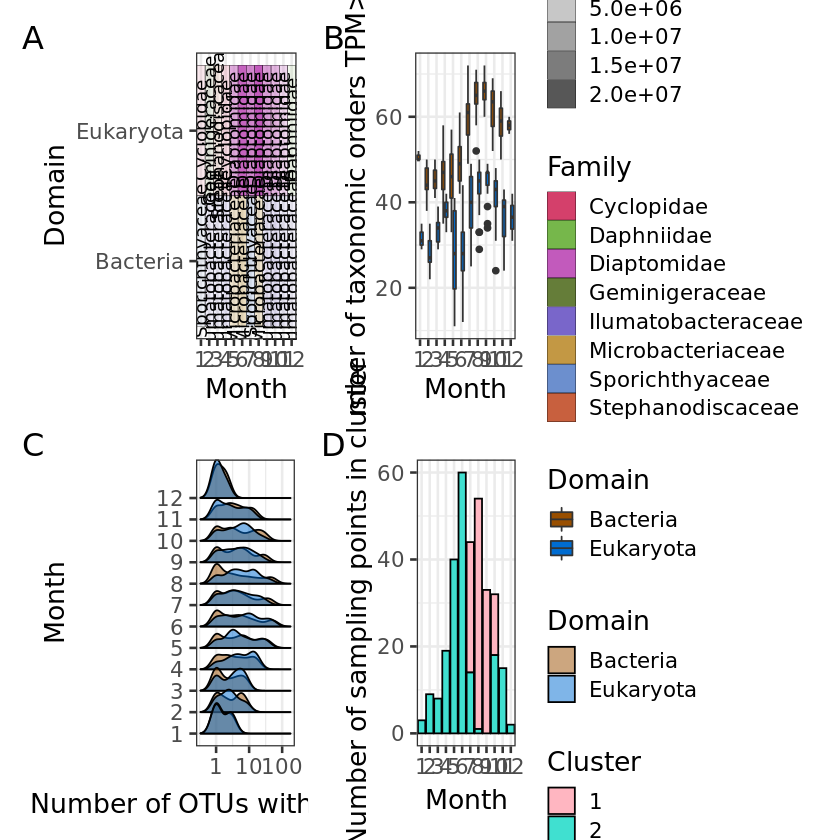

In [24]:
((top_order_plot | num_order_plot)/(num_high_abund_plot+cluster_plot)) + 
    plot_layout(guides = 'collect') + plot_annotation(tag_levels = 'A')
ggsave("../../figures/seasonality_plot.png",dpi=400,width=13,height=12,units="in")
ggsave("../../figures/seasonality_plot.pdf",dpi=400,width=13,height=12,units="in")

## Hierarchical clustering with individuals instead of samples

In [10]:
modified_abundance_frame_t = data.frame(t(for_plotting %>% dplyr::bind_rows(for_plotting_bact) %>% 
       dplyr::distinct(Label,Phylum,Class,Order,Family,Genus,SampleDate,.keep_all=TRUE) %>%
       tidyr::pivot_wider(id_cols=c(Label,Phylum,Class,Order,Family,Genus),
                          values_from="ZScore",names_from="SampleDate")%>% 
       dplyr::select(-c(Phylum,Class,Order,Family,Genus))))

colnames(modified_abundance_frame_t) <- as.character(modified_abundance_frame_t[1, ])
modified_abundance_frame_t <- modified_abundance_frame_t[-1,]
modified_abundance_frame_t = modified_abundance_frame_t %>% mutate_all(as.numeric)

In [15]:
fit_lab <- pvclust(modified_abundance_frame_t %>% 
               dplyr::filter(rownames(.) != "11Feb2005S"), 
               method.hclust="ward.D", method.dist="canberra",parallel=TRUE)

Creating a temporary cluster...done:
socket cluster with 35 nodes on host ‘localhost’
Multiscale bootstrap... Done.


In [16]:
pp_lab <- pvpick(fit_lab, alpha=0.80, pv="au", type="geq", max.only=TRUE)
clusters_lab = pp_lab$clusters
edge_frame = fit_lab$edges
cluster_ct = 1
all_df_lab = data.frame()
for (cluster in clusters_lab) {
    curr_append = (data_tree_euk %>% dplyr::bind_rows(data_tree_bact)) %>% 
                                                 dplyr::filter(Label %in% cluster) %>% 
                                                 select(Domain,Phylum,Class,Order,Family,Genus,Species,Label) %>%
                                                 dplyr::mutate(ClustNum = cluster_ct) %>%
                                                 dplyr::mutate(AU = edge_frame$au[cluster_ct])
    if (("Bacteria" %in% curr_append$Domain) & ("Eukaryota" %in% curr_append$Domain)) {
        all_df_lab = all_df_lab %>% dplyr::bind_rows(curr_append)
    } else {
        if (grepl("16S",paste0(cluster,collapse="|")) & grepl("18S",paste0(cluster,collapse="|"))) {
            print(cluster)
        }
    }
    cluster_ct = cluster_ct + 1
}

In [21]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

write.csv(all_df_lab %>% dplyr::filter(AU > 0.90) %>% dplyr::arrange(ClustNum) %>%
    dplyr::rename("AU_p_val"="AU","ClusterID"="ClustNum"),file.path("..","..","data","hierarchical_clust_mods.csv"))

In [29]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

all_df_lab %>% dplyr::filter(AU > 0.90)

Domain,Phylum,Class,Order,Family,Genus,Species,Label,ClustNum,AU
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Eukaryota,Ciliophora,Nassophorea,Nassulida,Nassulidae,Nassula,,MEND-TF-18S-277,7,1.0000000
Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Geobacteraceae,Geobacter,,MEND-TF-16S-906,7,1.0000000
Bacteria,Cyanobacteria,,Synechococcales,Chamaesiphonaceae,Chamaesiphon,,MEND-TF-16S-1134,7,1.0000000
Bacteria,Planctomycetes,Phycisphaerae,Phycisphaerales,Phycisphaeraceae,Phycisphaera,Phycisphaera mikurensis,MEND-TF-16S-979,7,1.0000000
Eukaryota,Apicomplexa,Conoidasida,Coccidia,Eucoccidiorida,Cryptosporidiidae,Cryptosporidium,MEND-TF-18S-307,21,0.9996481
Bacteria,Bacteroidetes,Saprospiria,Saprospirales,Haliscomenobacteraceae,Haliscomenobacter,,MEND-TF-16S-861,21,0.9996481
Bacteria,Bacteroidetes,Cytophagia,Cytophagales,Hymenobacteraceae,Adhaeribacter,,MEND-TF-16S-492,21,0.9996481
Bacteria,Proteobacteria,Alphaproteobacteria,Caulobacterales,Caulobacteraceae,Aquidulcibacter,,MEND-TF-16S-1160,21,0.9996481
Eukaryota,Endomyxa,,Vampyrellida,Leptophryidae,Vernalophrys,,MEND-TF-18S-107,25,1.0000000


In [30]:
all_df_lab %>% dplyr::filter(ClustNum %in% (all_df_lab %>% dplyr::filter(Order == "Rickettsiales"))$ClustNum)

Domain,Phylum,Class,Order,Family,Genus,Species,Label,ClustNum,AU
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Eukaryota,Ochrophyta,Coscinodiscophyceae,Aulacoseirales,Aulacoseiraceae,Aulacoseira,,MEND-TF-18S-133,63,0.8272865
Eukaryota,Oomycota,,Saprolegniales,Saprolegniaceae,Pythiopsis,,MEND-TF-18S-108,63,0.8272865
Bacteria,Cyanobacteria,,Synechococcales,Chamaesiphonaceae,Chamaesiphon,,MEND-TF-16S-1008,63,0.8272865
Bacteria,Proteobacteria,Alphaproteobacteria,Rickettsiales,Anaplasmataceae,Neorickettsia,Neorickettsia risticii,MEND-TF-16S-370,63,0.8272865
Eukaryota,Rotifera,Eurotatoria,Ploima,Brachionidae,Brachionus,,MEND-TF-18S-121,92,0.5834880
Eukaryota,Rotifera,Eurotatoria,Ploima,Brachionidae,Brachionus,,MEND-TF-18S-350,92,0.5834880
Eukaryota,Rotifera,Eurotatoria,Flosculariaceae,Flosculariidae,Floscularia,,MEND-TF-18S-120,92,0.5834880
Eukaryota,Rotifera,Eurotatoria,Flosculariaceae,Flosculariidae,Floscularia,,MEND-TF-18S-318,92,0.5834880
Eukaryota,Chlorophyta,Chlorophyceae,Chlamydomonadales,Volvocaceae,Colemanosphaera,,MEND-TF-18S-215,92,0.5834880


In [33]:
all_df_lab %>% dplyr::filter(ClustNum %in% (all_df_lab %>% dplyr::filter(Order == "Holosporales"))$ClustNum)

Domain,Phylum,Class,Order,Family,Genus,Species,Label,ClustNum,AU
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
